# Anomaly Detection

Anomaly detection in time series data plays a pivotal role in numerous sectors including finance, healthcare, security, and infrastructure. In essence, time series data represents a sequence of data points indexed (or listed or graphed) in time order, often with equal intervals. As systems and processes become increasingly digitized and interconnected, the need to monitor and ensure their normal behavior grows proportionally. Detecting anomalies can indicate potential problems, malfunctions, or even malicious activities. By promptly identifying these deviations from the expected pattern, organizations can take preemptive measures, optimize processes, or protect resources. `TimeGPT` includes the `detect_anomalies` method to detect anomalies automatically.

In [ ]:
#| hide
from nixtlats.utils import colab_badge

In [ ]:
#| echo: false
colab_badge('docs/tutorials/0_anomaly_detection')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/0_anomaly_detection.ipynb)

In [ ]:
#| hide
import numpy as np
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

True

In [ ]:
import pandas as pd
from nixtlats import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

In [ ]:
#| hide
nixtla_client = NixtlaClient()

The `detect_anomalies` method is designed to process a dataframe containing series and subsequently label each observation based on its anomalous nature. The method evaluates each observation of the input dataframe against its context within the series, using statistical measures to determine its likelihood of being an anomaly. By default, the method identifies anomalies based on a 99 percent prediction interval. Observations that fall outside this interval are considered anomalies. The resultant dataframe will feature an added label, `anomaly`, that is set to 1 for anomalous observations and 0 otherwise.

In [ ]:
pm_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/peyton_manning.csv')
timegpt_anomalies_df = nixtla_client.detect_anomalies(pm_df, time_col='timestamp', target_col='value', freq='D')
timegpt_anomalies_df.head()

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Anomaly Detector Endpoint...


,timestamp,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
0,2008-01-10,0,6.936009,8.224194,9.512378
1,2008-01-11,0,6.863336,8.151521,9.439705
2,2008-01-12,0,6.839064,8.127249,9.415433
3,2008-01-13,0,7.629072,8.917256,10.205441
4,2008-01-14,0,7.714111,9.002295,10.290480


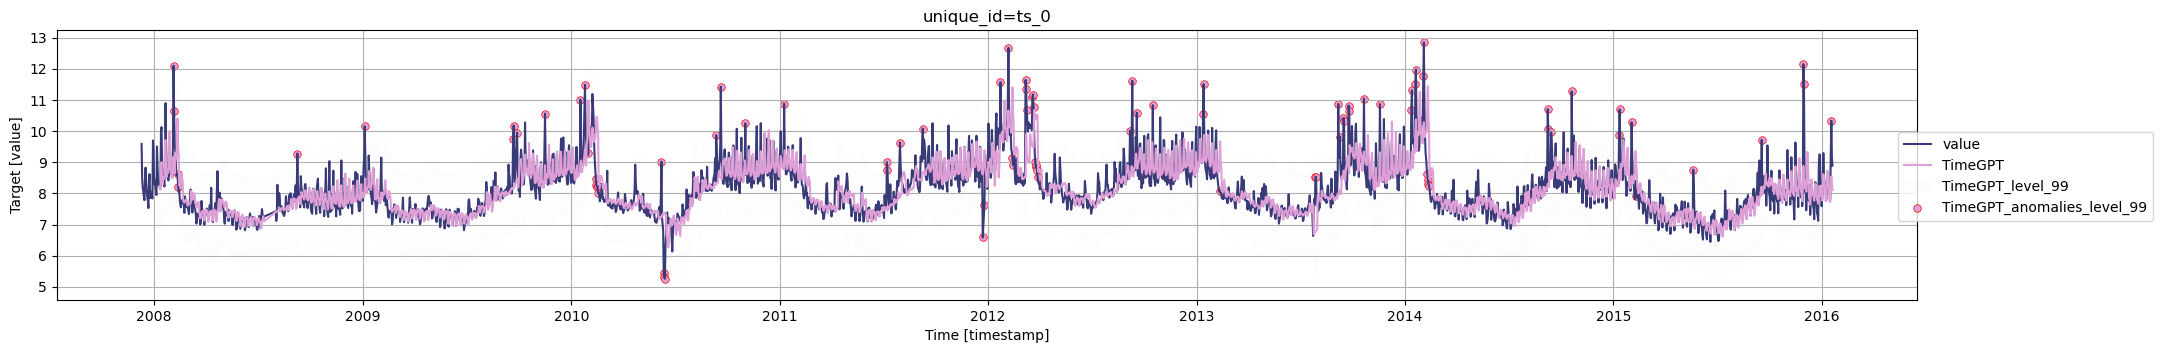

In [ ]:
nixtla_client.plot(pm_df, 
             timegpt_anomalies_df,
             time_col='timestamp', 
             target_col='value')

In [ ]:
#| hide
# get historical prediction intervals to test against 
# the anomalies detected
level = [99, 90, 99.99]
pm_fcst = nixtla_client.forecast(pm_df, h=1, time_col='timestamp', 
                           target_col='value', freq='D', 
                           add_history=True, 
                           level=[99, 90, 99.99])
pm_fcst = pm_fcst.merge(pm_df)
for lv in level:
    pm_fcst[f'anomaly_{lv}'] = (pm_fcst['value'] > pm_fcst[f'TimeGPT-hi-{lv}']) | (pm_fcst['value'] < pm_fcst[f'TimeGPT-lo-{lv}'])
    pm_fcst[f'anomaly_{lv}'] = pm_fcst[f'anomaly_{lv}'].astype(np.int64)

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Calling Historical Forecast Endpoint...


In [ ]:
#| hide
# test 99 intervals
pd.testing.assert_series_equal(
    pm_fcst['anomaly_99'],
    timegpt_anomalies_df.merge(pm_df)['anomaly'],
    check_index=False,
    check_names=False,
)

While the default behavior of the detect_anomalies method is to operate using a 99 percent prediction interval, users have the flexibility to adjust this threshold to their requirements. This is achieved by modifying the `level` argument. Decreasing the value of the level argument will result in a narrower prediction interval, subsequently identifying more observations as anomalies. See the next example.

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Anomaly Detector Endpoint...


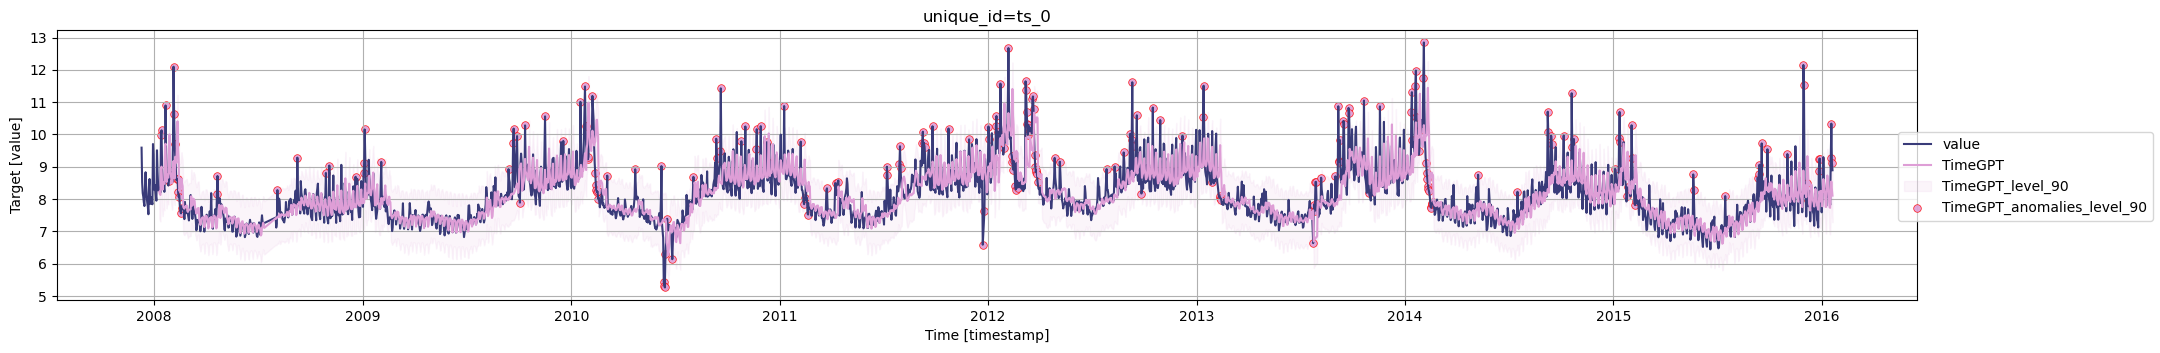

In [ ]:
timegpt_anomalies_df = nixtla_client.detect_anomalies(pm_df, time_col='timestamp', target_col='value', freq='D', level=90)
nixtla_client.plot(pm_df, 
             timegpt_anomalies_df,
             time_col='timestamp', 
             target_col='value')

In [ ]:
#| hide
# test 99 intervals
pd.testing.assert_series_equal(
    pm_fcst['anomaly_90'],
    timegpt_anomalies_df.merge(pm_df)['anomaly'],
    check_index=False,
    check_names=False,
)

Conversely, increasing the value will make prediction intervals larger, detecting fewer anomalies. This customization allows users to calibrate the sensitivity of the method to align with their specific use case, ensuring the most relevant and actionable insights are derived from the data.

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Anomaly Detector Endpoint...


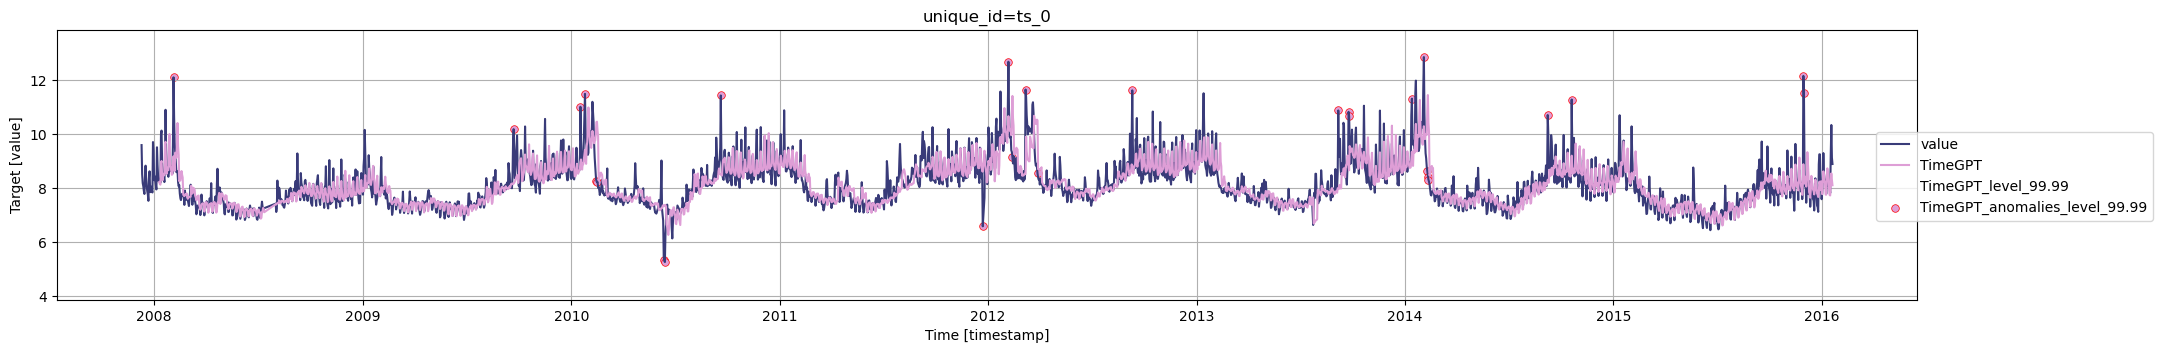

In [ ]:
timegpt_anomalies_df = nixtla_client.detect_anomalies(pm_df, time_col='timestamp', target_col='value', freq='D', level=99.99)
nixtla_client.plot(pm_df, 
             timegpt_anomalies_df,
             time_col='timestamp', 
             target_col='value')

In [ ]:
#| hide
# test 99 intervals
pd.testing.assert_series_equal(
    pm_fcst['anomaly_99.99'],
    timegpt_anomalies_df.merge(pm_df)['anomaly'],
    check_index=False,
    check_names=False,
)

You can also include `date_features` to better detect anomalies:

In [ ]:
#| hide
# get historical prediction intervals to test against 
# the anomalies detected
# with exogenous variables
level = [99, 90, 99.99]
pm_fcst_x = nixtla_client.forecast(
    pm_df, h=1, time_col='timestamp', 
    target_col='value', freq='D', 
    add_history=True, 
    date_features=True,
    level=[99, 90, 99.99],
)
pm_fcst_x = pm_fcst_x.merge(pm_df)
for lv in level:
    pm_fcst_x[f'anomaly_{lv}'] = (pm_fcst_x['value'] > pm_fcst_x[f'TimeGPT-hi-{lv}']) | (pm_fcst_x['value'] < pm_fcst_x[f'TimeGPT-lo-{lv}'])
    pm_fcst_x[f'anomaly_{lv}'] = pm_fcst_x[f'anomaly_{lv}'].astype(np.int64)

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Using the following exogenous variables: year_2007, year_2008, year_2009, year_2010, year_2011, year_2012, year_2013, year_2014, year_2015, year_2016, month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12, day_1, day_2, day_3, day_4, day_5, day_6, day_7, day_8, day_9, day_10, day_11, day_12, day_13, day_14, day_15, day_16, day_17, day_18, day_19, day_20, day_21, day_22, day_23, day_24, day_25, day_26, day_27, day_28, day_29, day_30, day_31, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Calling Historical Forecast Endpoint...


INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtlats.nixtla_client:Using the following exogenous variables: year_2007, year_2008, year_2009, year_2010, year_2011, year_2012, year_2013, year_2014, year_2015, year_2016, month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12, day_1, day_2, day_3, day_4, day_5, day_6, day_7, day_8, day_9, day_10, day_11, day_12, day_13, day_14, day_15, day_16, day_17, day_18, day_19, day_20, day_21, day_22, day_23, day_24, day_25, day_26, day_27, day_28, day_29, day_30, day_31, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6


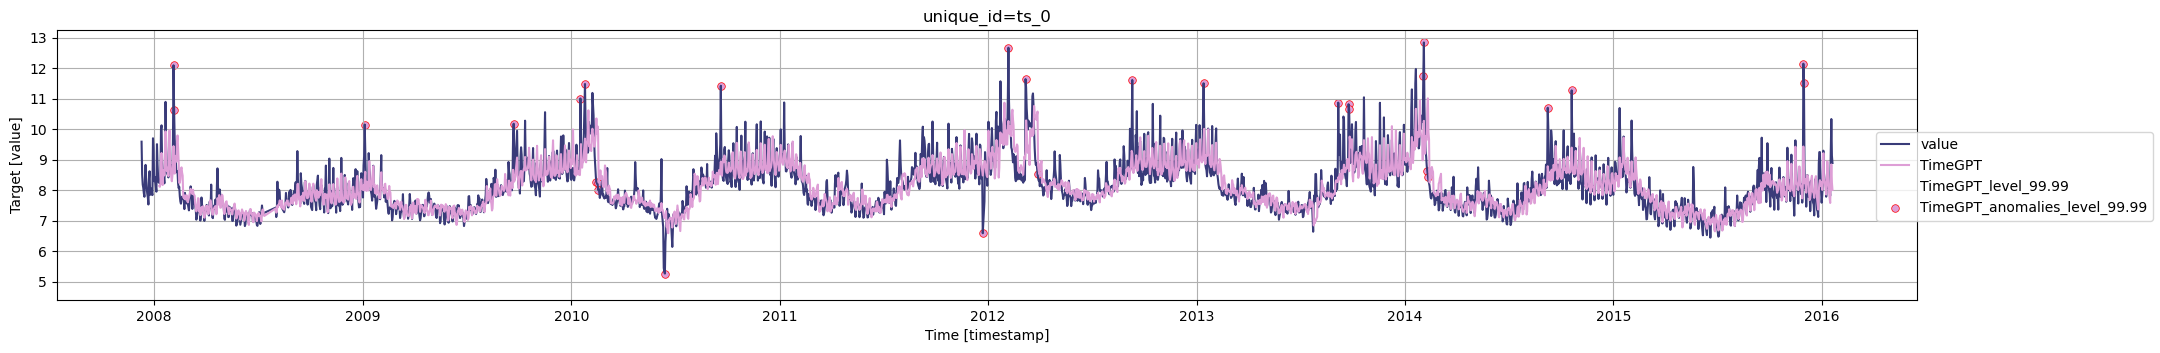

In [ ]:
timegpt_anomalies_df_x = nixtla_client.detect_anomalies(
    pm_df, time_col='timestamp', 
    target_col='value', 
    freq='D', 
    date_features=True,
    level=99.99,
)
nixtla_client.plot(
    pm_df, 
    timegpt_anomalies_df_x,
    time_col='timestamp', 
    target_col='value',
)

In [ ]:
#| hide
# test 99 intervals
pd.testing.assert_series_equal(
    pm_fcst_x['TimeGPT-lo-99.99'],
    timegpt_anomalies_df_x.merge(pm_df)['TimeGPT-lo-99.99'],
    check_index=False,
    check_names=False,
    rtol=1,
    atol=1,
)

#### Exogenous variables

Additionally you can pass exogenous variables to better inform `TimeGPT` about the data. You just simply have to add the exogenous regressors after the target column.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-01 00:00:00,72.00,61507.0,71066.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,BE,2016-12-01 01:00:00,65.80,59528.0,67311.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,BE,2016-12-01 02:00:00,59.99,58812.0,67470.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,BE,2016-12-01 03:00:00,50.69,57676.0,64529.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,BE,2016-12-01 04:00:00,52.58,56804.0,62773.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now let's compute anomalies considering this information

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: H
INFO:nixtlats.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtlats.nixtla_client:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6


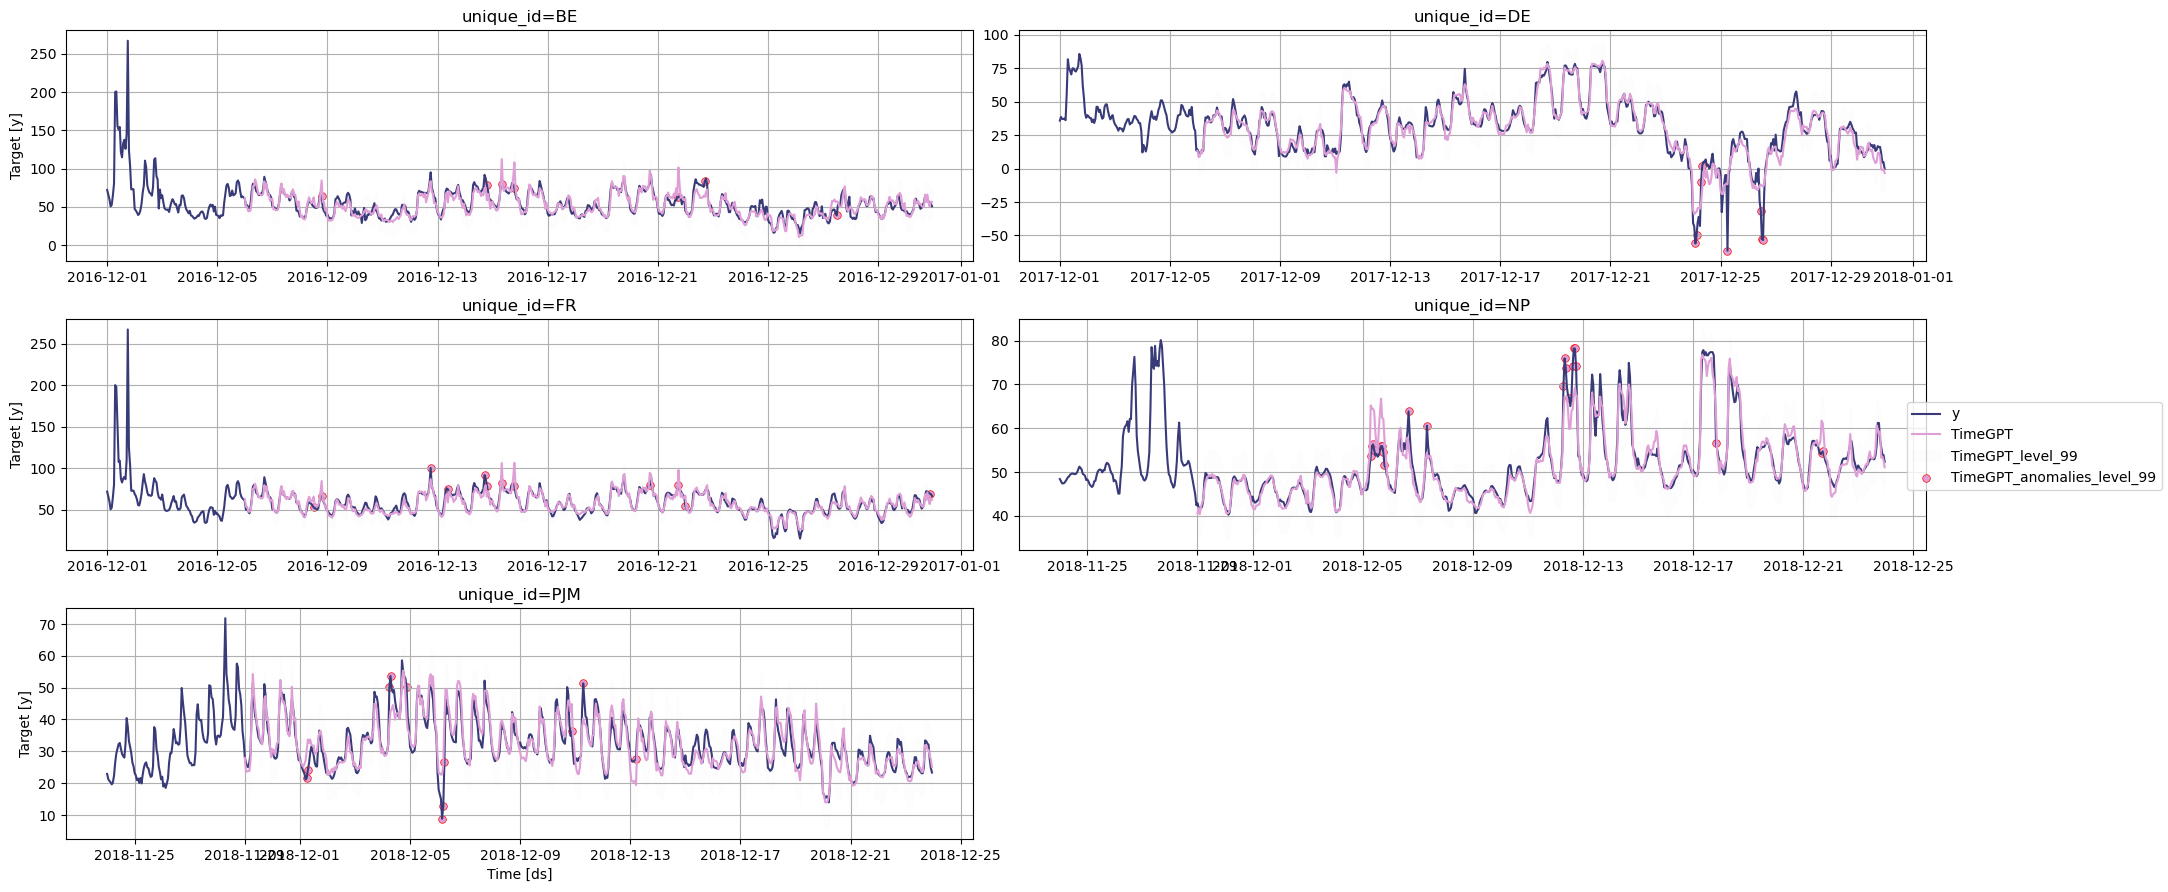

In [ ]:
timegpt_anomalies_df_x = nixtla_client.detect_anomalies(df=df)
nixtla_client.plot(
    df, 
    timegpt_anomalies_df_x,
)

We can also explore the relative importance of each of the features.

<Axes: ylabel='features'>

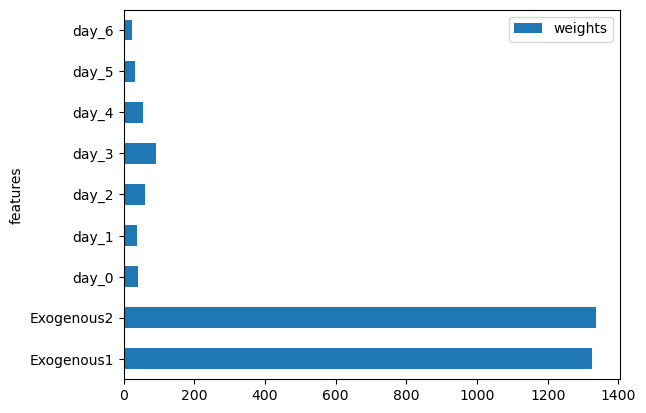

In [ ]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')

You can also add special days for different countries:

In [ ]:
from nixtlats.date_features import CountryHolidays

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: H
INFO:nixtlats.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtlats.nixtla_client:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6, FR_Jour de l'an, FR_Fête du Travail, FR_Fête de la Victoire, FR_Fête nationale, FR_Armistice, FR_Lundi de Pâques, FR_Lundi de Pentecôte, FR_Ascension, FR_Assomption, FR_Toussaint, FR_Noël


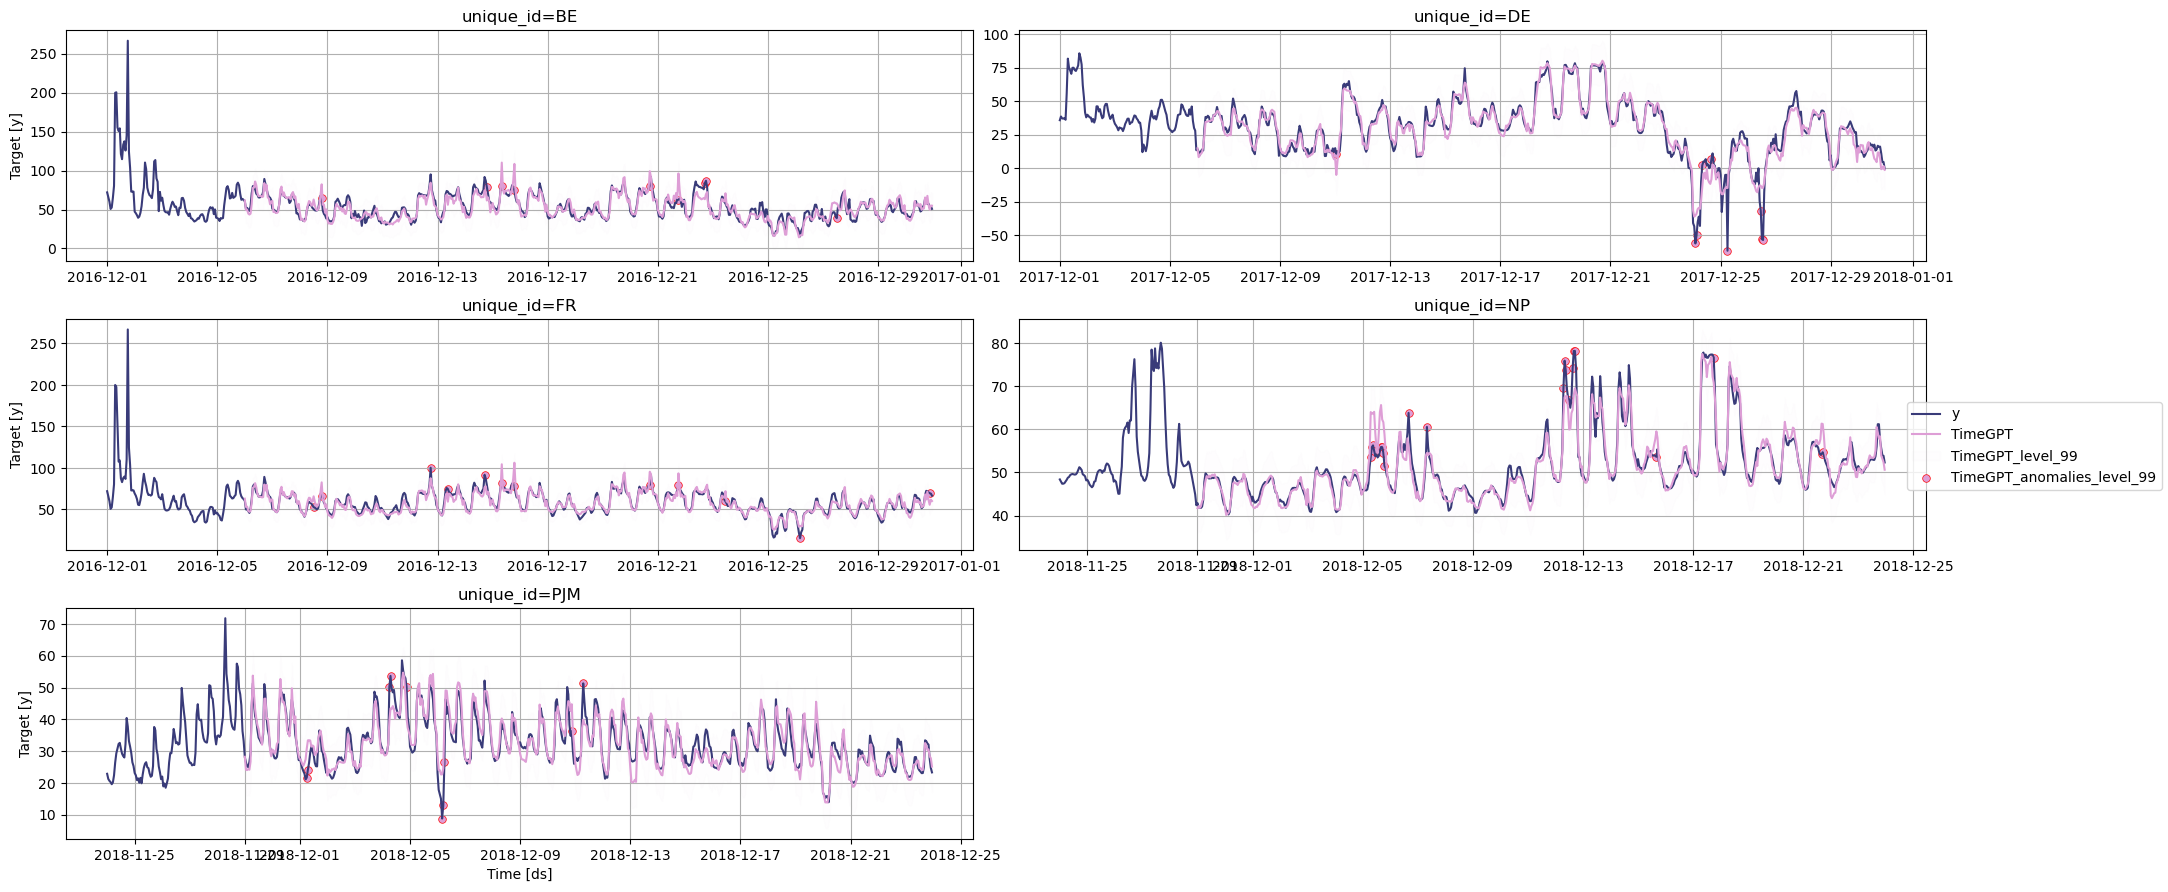

In [ ]:
timegpt_anomalies_df_x = nixtla_client.detect_anomalies(
    df=df,
    date_features=[CountryHolidays(countries=['FR'])]
)
nixtla_client.plot(
    df, 
    timegpt_anomalies_df_x,
)

<Axes: ylabel='features'>

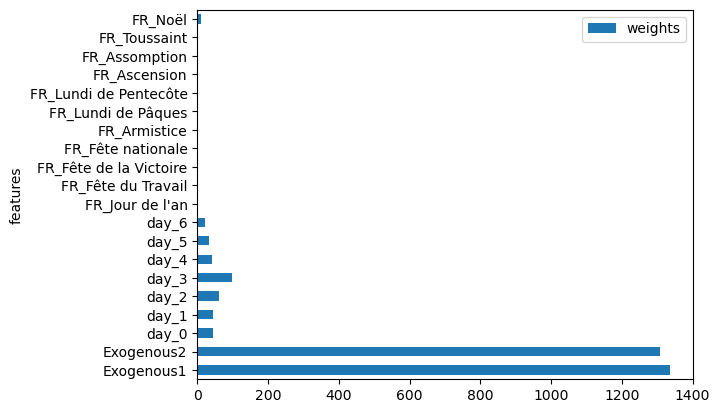

In [ ]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')